## ResNet Implementations
In this jupyter notebook I implement the Resent18, Resnet34 and Resnet50 architectures as proposed in the paper:

He et al., 2015. Deep residual networks for image recognition
https://arxiv.org/pdf/1512.03385.pdf

The proposed models in the paper were created to fascilitate the training and use of very deep neural networks as the norm is that the deeper the neural net is, the more accurate it is as it is able to learn more complicated mathematical functions. 

The issue the author's identified with regards to training of deep neural networks is that of vanishing/exploding gradients. In a neural network, gradient descent through back propogation works with gradient learning trickling down from deeper layers to lower layers. Which means that the learning value: learning_rate * (gradient) decreases the more backwards one goes through the network. In very large models, this means that the lower layers have either static gradients (vanishing) or exploding gradients as only few neurons out of many are activated continuously and can become extremely large and cause instability in training. These phenomenon are also called "degradation".

To solve these issues, the authors came up with the Residual Block. In this, there are skip connections which directly feeds the output of one layer to another layer which is deeper in the network- hence skipping some layers, like a shortcut. The residual function is the difference between the expected output and the input to a particular layer. It allows the network to focus on learning incremental changes (residuals) instead of attempting to learn the entire mapping from scratch, the training process becomes more manageable and convergence is improved.The residual function can easily learn the identiy mapping or get close. This means for backpropogation, lower layers are more easily influenced by changes in the deeper layers. This solves to a great degree the issue of degradation. 

The authors showcase ResNets' capability to achieve significantly increased depth, up to 152 layers, outperforming VGG nets with lower complexity. Notably, an ensemble of these ResNets achieves a remarkable 3.57% error rate on the ImageNet test set, securing the top spot in the ILSVRC 2015 classification challenge. The paper also highlights the impact of deep representations, showcasing a substantial 28% relative improvement in COCO object detection. Their ResNet-based submissions dominate the ILSVRC & COCO 2015 competitions, achieving 1st place in various tasks including ImageNet detection, localization, COCO detection, and segmentation.



Here we import the necessary libraries. We are using the Tensorflow API.

In [17]:
import tensorflow as tf
import numpy as np
import scipy.misc
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import random_uniform, HeNormal, constant, identity
from tensorflow.keras.optimizers.legacy import SGD

### Pre-processing

I use the coffee beans dataset. It consists of 4 classes: Dark, Green, Light and Medium. The dataset is already divided into train (consisting of 1200 images: 300 per class) and test (consisting of 400 images: 100 per class). In the original paper, 224x224 crops are taken from the ImageNet data, however the coffee beans dataset is already at 224x224 size. In the paper the authors use per pixel mean subtraction for normalization however we divide the values by 255 as that is common practice right now. Furthermore the authors use a batch size of 256 but I use 32 as the dataset I use is much smaller. 

In [18]:
import pathlib
data_dir = pathlib.Path("/kaggle/input/coffee-bean-dataset-resized-224-x-224/train")
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*')])
print(CLASS_NAMES)

['Dark' 'Green' 'Light' 'Medium']


In [19]:
BATCH_SIZE = 32         
IMG_HEIGHT = 224           
IMG_WIDTH = 224            

image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
train_data_gen = image_generator.flow_from_directory(directory=str("/kaggle/input/coffee-bean-dataset-resized-224-x-224/train"),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))
valid_data_gen = image_generator.flow_from_directory(directory=str("/kaggle/input/coffee-bean-dataset-resized-224-x-224/test"),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))

Found 1200 images belonging to 4 classes.
Found 400 images belonging to 4 classes.


### Skip Connections

Resnet18 and Resnet34 are different from Resnet50 and larger models in that the skip connections in Resnet18 and Resnet34 skip over two layer whereas in Resnet50 and above they skip over 3 layers. In this notebook we denote the skip connections that skip over 2 as Skip2 and those that skip over 3 as Skip3. 

There are two kinds of residual blocks: Identity Blocks and Down-Sampling/Convolutional Blocks. 

The identity block has two pathways. The main path ways consists of a series of convolutional and batch norm layers with "same" padding hence preserving the size/dimensions of the input into the block. The second pathway directly adds the initial input to the output of the first pathway, and because they are of same dimensions, they can be added directly. This is the residual block that can take the value of identity mappings. Relu activation is used in the first layer and after the two pathways have been added. 



In [20]:
def Skip2_IdentityBlock(X,kernel_size,num_filters):
    
    X_shortcut = X
    
    X = Conv2D(kernel_size=kernel_size, filters=num_filters, strides=(1,1), padding='same')(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    
    X = Conv2D(kernel_size=kernel_size, filters=num_filters, strides=(1,1), padding='same')(X)
    X = BatchNormalization(axis = 3)(X)
      
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X 

The down-sampling block has two pathways. The main pathway consists of a series of convolutional and batch norm layers, however the first convolutional layer has a "valid" padding which means it reduces the dimensionality. To match this in the second pathway, the input is also passed through a convolutional layer with similar "valid" padding, kernel size and stride. These pathways are then added and the Relu activation function is applied onto these. This residual block cannot easily assume the form of identity mapping but performs the task of downsampling the image size which is seen in all convolutional neural networks.

In [21]:
def Skip2_DownSamplingBlock(X,kernel_size,num_filters,stride):
    
    X_shortcut = X
    
    X = Conv2D(kernel_size=kernel_size, filters=num_filters, strides=stride, padding='valid',kernel_initializer = HeNormal())(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    
    X = Conv2D(kernel_size=kernel_size, filters=num_filters, strides=(1,1), padding='same',kernel_initializer = HeNormal())(X)
    X = BatchNormalization(axis = 3)(X)
    
    X_shortcut = Conv2D(kernel_size=kernel_size, filters=num_filters, strides=stride, padding='valid',kernel_initializer = HeNormal())(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut)

    
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X


Resnet18 and Resnet34 are then implemented below. We pass in an image of size 224x224x3 for 3 colour channels RGB. We pad it to 3 pixels on all borders. This is as it is done in the original paper. With this, the dimension calculations of the convolutions will match the original paper. For Resnet18 and Resnet34, the Skip2 connections are used. The only difference between them is the number of such residual blocks. The first and final stages are same for both. The input is convolved, passed through a batch norm layer, activated using Relu and MaxPooling is applied to the result. The hyperparameters of all the layers are as described in the original paper. 

In [22]:
def ResNet18(num_classes, input_shape = (224, 224, 3), training=False): 
    
    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = HeNormal())(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    
    #Stage 2
    X = Skip2_IdentityBlock(X, 3, 64)
    X = Skip2_IdentityBlock(X, 3, 64)
    
    #Stage 3
    X = Skip2_DownSamplingBlock(X, 3, 128, 2)
    X = Skip2_IdentityBlock(X, 3, 128)
    
    #Stage 4
    X = Skip2_DownSamplingBlock(X, 3, 256, 2)
    X = Skip2_IdentityBlock(X, 3, 256)
    
    #Stage 5
    X = Skip2_DownSamplingBlock(X, 3, 512, 2)
    X = Skip2_IdentityBlock(X, 3, 512)
    
    #Stage 6
    X = AveragePooling2D()(X)
    
    X = Flatten()(X)
    X = Dense(num_classes, activation='softmax', kernel_initializer = HeNormal())(X)

    model = Model(inputs = X_input, outputs = X)

    return model

In [23]:
def ResNet34(num_classes, input_shape = (224, 224, 3), training=False): #what does Training=False do? 
    
    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = HeNormal())(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    
    #Stage 2
    X = Skip2_IdentityBlock(X, 3, 64)
    X = Skip2_IdentityBlock(X, 3, 64)
    X = Skip2_IdentityBlock(X, 3, 64)
    
    #Stage 3
    X = Skip2_DownSamplingBlock(X, 3, 128, 2)
    X = Skip2_IdentityBlock(X, 3, 128)
    X = Skip2_IdentityBlock(X, 3, 128)
    X = Skip2_IdentityBlock(X, 3, 128)
    
    #Stage 4
    X = Skip2_DownSamplingBlock(X, 3, 256, 2)
    X = Skip2_IdentityBlock(X, 3, 256)
    X = Skip2_IdentityBlock(X, 3, 256)
    X = Skip2_IdentityBlock(X, 3, 256)
    X = Skip2_IdentityBlock(X, 3, 256)
    X = Skip2_IdentityBlock(X, 3, 256)
    
    #Stage 5
    X = Skip2_DownSamplingBlock(X, 3, 512, 2)
    X = Skip2_IdentityBlock(X, 3, 512)
    X = Skip2_IdentityBlock(X, 3, 512)
    
    #Stage 6
    X = AveragePooling2D()(X)
    
    X = Flatten()(X)
    X = Dense(num_classes, activation='softmax', kernel_initializer = HeNormal())(X)

    model = Model(inputs = X_input, outputs = X)

    return model

We initialize the model to Resnet18. We could also change it to initialize to Resnet34 by using:

model = ResNet34(input_shape = (224, 224, 3), num_classes = 4)

In [24]:
model = ResNet18(input_shape = (224, 224, 3), num_classes = 4)

As described in the paper, a momentum of 0.9 and weight decay of 0.0001 is used. The paper describes starting with the learning rate 0.1 and dividing it by 10 every time the error falls rapidly. We implement a standard learning rate of 0.001 as a more complex implementation of learning rate doesnt help us in the coffee beans dataset. We use accuracy as our metric and categorical cross entropy as our loss function.

In [25]:
optimizer = SGD(learning_rate=0.001, momentum=0.9, decay=0.0001)

model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

In [26]:
history = model.fit(train_data_gen, validation_data=valid_data_gen, validation_freq=1, epochs = 20)

Epoch 1/20
38/38 [==============================] - 9s 171ms/step - loss: 0.4887 - accuracy: 0.7958 - val_loss: 10.8800 - val_accuracy: 0.2175
Epoch 2/20
38/38 [==============================] - 6s 161ms/step - loss: 0.1820 - accuracy: 0.9358 - val_loss: 3.3468 - val_accuracy: 0.2700
Epoch 3/20
38/38 [==============================] - 7s 183ms/step - loss: 0.0828 - accuracy: 0.9700 - val_loss: 1.3557 - val_accuracy: 0.4575
Epoch 4/20
38/38 [==============================] - 6s 149ms/step - loss: 0.1030 - accuracy: 0.9658 - val_loss: 2.5545 - val_accuracy: 0.2700
Epoch 5/20
38/38 [==============================] - 6s 146ms/step - loss: 0.0430 - accuracy: 0.9833 - val_loss: 1.9445 - val_accuracy: 0.4800
Epoch 6/20
38/38 [==============================] - 6s 148ms/step - loss: 0.0156 - accuracy: 0.9950 - val_loss: 1.4179 - val_accuracy: 0.5850
Epoch 7/20
38/38 [==============================] - 6s 165ms/step - loss: 0.0237 - accuracy: 0.9900 - val_loss: 0.8430 - val_accuracy: 0.6650
Epoch

We observe that over 20 epochs Resnet has learnt to predict the validation set extremely well :) Perhaps stopping it earlier would also give us better results. 

Below, we plot the accuracy history and we can visualize the learning of the model

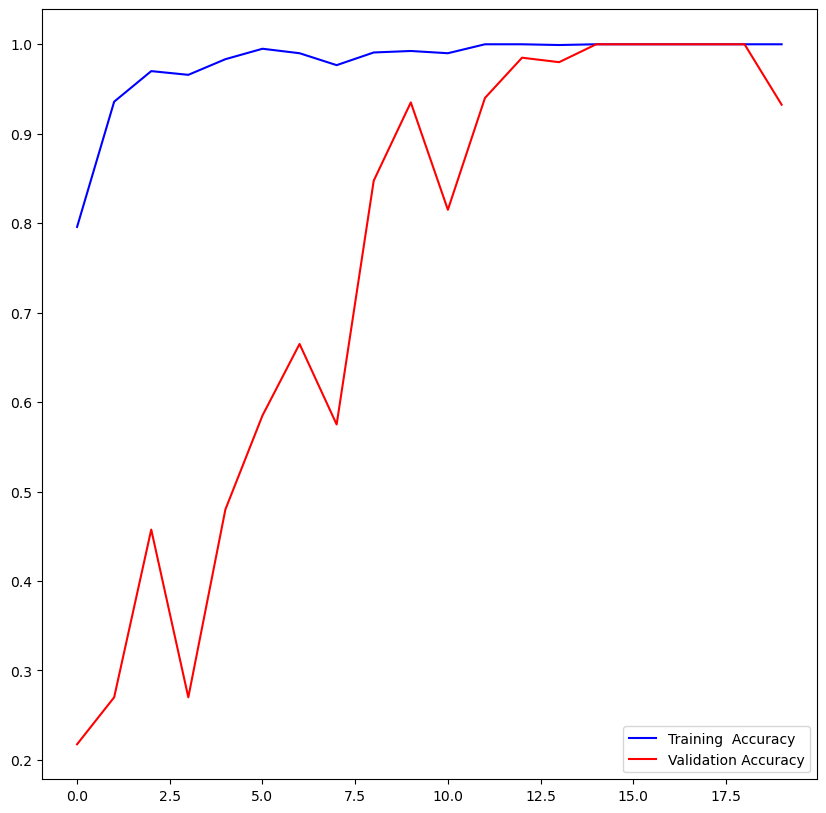

In [27]:
import matplotlib.pyplot as plt
f,ax=plt.subplots(1,1,figsize=(10,10)) 

#Plotting the training accuracy and validation accuracy
ax.plot(model.history.history['accuracy'],color='b',label='Training  Accuracy')
ax.plot(model.history.history['val_accuracy'],color='r',label='Validation Accuracy')

plt.legend()

Resnet50 and beyond use skip3 connections. These involve one convolutional layer of kernel size 1, another of kernel size 3 and finally one of kernel size 1. There are also two types which can be called identity blocks and down-sampling blocks. The principle of working of these blocks is similar to the Skip2 connections. The only difference between Resnet50 and larger variants is the number of blocks which can be changed by anyone that wants to use this code for their own Resnet. 

In [28]:
def Skip3_IdentityBlock(X,kernel_size,initial_num_filters,final_num_filters):
    
    X_shortcut = X
    
    X = Conv2D(kernel_size=(1,1), filters=initial_num_filters, strides=(1,1), padding='valid', kernel_initializer = HeNormal())(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    
    X = Conv2D(kernel_size=kernel_size, filters=initial_num_filters, strides=(1,1), padding='same', kernel_initializer = HeNormal())(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    
    X = Conv2D(kernel_size=(1,1), filters=final_num_filters, strides=(1,1), padding='valid', kernel_initializer = HeNormal())(X)
    X = BatchNormalization(axis = 3)(X)
    
    # Adjust the dimensions of X_shortcut to match the number of final_num_filters
    X_shortcut = Conv2D(kernel_size=(1, 1), filters=final_num_filters, strides=(1, 1), padding='valid', kernel_initializer = HeNormal())(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut)
    
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X 

In [29]:
def Skip3_DownSamplingBlock(X,kernel_size,initial_num_filters,final_num_filters,stride):
    
    X_shortcut = X
    
    X = Conv2D(kernel_size=(1,1), filters=initial_num_filters, strides=stride, padding='valid', kernel_initializer = HeNormal())(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    
    X = Conv2D(kernel_size=kernel_size, filters=initial_num_filters, strides=(1,1), padding='same',kernel_initializer = HeNormal())(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    
    X = Conv2D(kernel_size=(1,1), filters=final_num_filters, strides=(1,1), padding='valid', kernel_initializer = HeNormal())(X)
    X = BatchNormalization(axis = 3)(X)
    
    X_shortcut = Conv2D(kernel_size=(1,1), filters=final_num_filters, strides=stride, padding='valid',kernel_initializer = HeNormal())(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut)
    
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [30]:
def ResNet50(num_classes, input_shape = (224, 224, 3), training=False):
    
    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = HeNormal())(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    
    #Stage 2
    X = Skip3_IdentityBlock(X, 3, 64, 256)
    X = Skip3_IdentityBlock(X, 3, 64, 256)
    X = Skip3_IdentityBlock(X, 3, 64, 256)
    
    #Stage 3
    X = Skip3_DownSamplingBlock(X, 3, 128, 152, 2)
    X = Skip3_IdentityBlock(X, 3, 128, 152)
    X = Skip3_IdentityBlock(X, 3, 128, 152)
    X = Skip3_IdentityBlock(X, 3, 128, 152)
    
    #Stage 4
    X = Skip3_DownSamplingBlock(X, 3, 256, 1024, 2)
    X = Skip3_IdentityBlock(X, 3, 256, 1024)
    X = Skip3_IdentityBlock(X, 3, 256, 1024)
    X = Skip3_IdentityBlock(X, 3, 256, 1024)
    X = Skip3_IdentityBlock(X, 3, 256, 1024)
    X = Skip3_IdentityBlock(X, 3, 256, 1024)
    
    #Stage 5
    X = Skip3_DownSamplingBlock(X, 3, 512, 2048, 2)
    X = Skip3_IdentityBlock(X, 3, 512, 2048)
    X = Skip3_IdentityBlock(X, 3, 512, 2048)
    
    #Stage 6
    X = AveragePooling2D()(X)
    
    X = Flatten()(X)
    X = Dense(num_classes, activation='softmax', kernel_initializer = HeNormal())(X)

    model = Model(inputs = X_input, outputs = X)

    return model

    

Below we observe that Resnet50 works as expected.

In [31]:
model_resnet50 = ResNet50(input_shape = (224, 224, 3), num_classes = 4)
optimizer = SGD(learning_rate=0.001, momentum=0.9, decay=0.0001)
model_resnet50.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history_resnet50 = model_resnet50.fit(train_data_gen, validation_data=valid_data_gen, validation_freq=1, epochs = 20)

Epoch 1/20
38/38 [==============================] - 18s 298ms/step - loss: 1.5714 - accuracy: 0.5642 - val_loss: 4255840.0000 - val_accuracy: 0.2500
Epoch 2/20
38/38 [==============================] - 11s 278ms/step - loss: 0.8169 - accuracy: 0.7175 - val_loss: 91129.4609 - val_accuracy: 0.2500
Epoch 3/20
38/38 [==============================] - 10s 264ms/step - loss: 0.6030 - accuracy: 0.7708 - val_loss: 15057.5254 - val_accuracy: 0.2500
Epoch 4/20
38/38 [==============================] - 10s 268ms/step - loss: 0.5554 - accuracy: 0.7975 - val_loss: 2656.6460 - val_accuracy: 0.2500
Epoch 5/20
38/38 [==============================] - 10s 267ms/step - loss: 0.4520 - accuracy: 0.8400 - val_loss: 718.8818 - val_accuracy: 0.2500
Epoch 6/20
38/38 [==============================] - 10s 268ms/step - loss: 0.4041 - accuracy: 0.8558 - val_loss: 138.5590 - val_accuracy: 0.3625
Epoch 7/20
38/38 [==============================] - 10s 265ms/step - loss: 0.4301 - accuracy: 0.8425 - val_loss: 33.2590 

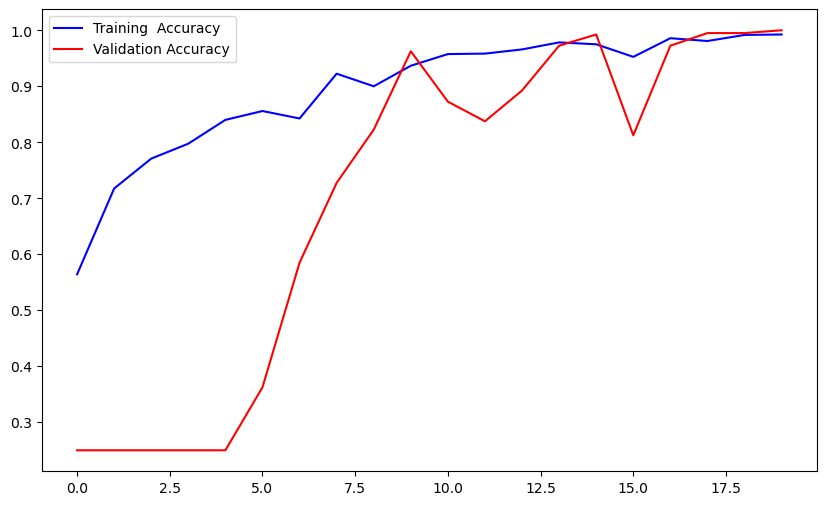

In [32]:
import matplotlib.pyplot as plt 
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
#Plotting the training accuracy and validation accuracy
ax.plot(model_resnet50.history.history['accuracy'],color='b',label='Training  Accuracy')
ax.plot(model_resnet50.history.history['val_accuracy'],color='r',label='Validation Accuracy')

plt.legend()

Thank you for reading through the jupyter notebook! I hope you found it useful for your own applications. 